## Predicting Sales of Walmart Products

**Team:**
* Rudraksh Mishra
* Ambika Chundru

**Course:** DAAN 897– Deep Learning (Spring II, 2022)

### Problem Statement
* The main objective is to estimate or predict the unit sales of Walmart retail goods at stores in various locations for the next 28-days, and 180 days.

    
    
    
* **Keywords:** sales price prediction, retail predection ,LSTM, CNN, DA-RNN
	

### Introduction

In the retail industry, forecasting sales accurately is important as this will help improve the revenue by avoiding can avoid wastages and shortages of products. 
Walmart shared its historical sales data on Kaggle as an M5 competition to enhance its forecasting models. 


### Data Collection
* Source(url):https://www.kaggle.com/c/m5-forecasting-accuracy/data
* Short Description : The 5 years time-series sales data set of various product over various stores was published on Kaggle for the M5 completion.


### Required packages
#!pip install pydotplus 

#!pip install pydot 

#!pip install graphviz



### Load Data

In [35]:
#impoert required libraries
import numpy as np 
import pandas as pd 

import os
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder

#load the required data
train_sales_initial = pd.read_csv('proj/sales_train_evaluation.csv')
calendar = pd.read_csv('proj/calendar.csv')
test= pd.read_csv('proj/sales_test_evaluation.csv')

## Data Preprocessing

### Downcasting
Downcasting the dataframes helps to reduce the amount of storage used by them and also to expidite the operations performed on them.

In [36]:
#To reduce memory usage
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

#Reduce memory usage and compare with the previous one to be sure
train_sales_downcast = downcast_dtypes(train_sales_initial)

## Preprocess dataset

There are several goods with zero pricing from day 1 to day 350, according to the sale price dataset. This is owing to the fact that the product has not yet been added to the store. Additionally, there are several goods with 0 sales in the sales train dataset, which might be owing to zero pricing or the fact that the sales were not recorded.
We need to establish a cutoff data instead of cutting the dataset by the first non-zero prices since our LSTM model predicts future sales of numerous items rather than individual products. As a result, we chose day 350 as the cutoff date.

In [37]:
# Preprocess: remove id, item_id, dept_id, cat_id, store_id, state_id columns
startDay = 350  # Remove the first 350 days in train sales
train_sales_transposed = train_sales_initial.T
train_sales_final = train_sales_transposed[6 + startDay:]

## event 1, event 2 and SNAP
Apart from utilizing sales as a time series element, festive or sporting events can have a big impact on sales. A day before Thanksgiving or the Superbowl, for example, buyers are more inclined to buy additional snacks or meals. Similarly, with the SNAP program, we anticipate more sales during the day. As a result, we added five new features: event 1, event 2, SNAP CA, SNAP WI, and SNAP TX. Because each shop location's SNAP program days are different, we require three distinct SNAP features.

In [38]:
# Initialize a dataframe with zeros for 1969 days in the calendar

daysBeforeEvent1 = pd.DataFrame(np.zeros((1969,1)))
daysBeforeEvent2 = pd.DataFrame(np.zeros((1969,1)))

snap_CA = pd.DataFrame(np.zeros((1969,1)))
snap_TX = pd.DataFrame(np.zeros((1969,1)))
snap_WI = pd.DataFrame(np.zeros((1969,1)))


for x,y in calendar.iterrows():
    if((pd.isnull(calendar["event_name_1"][x])) == False):
           daysBeforeEvent1[0][x-1] = 1 
            
    if((pd.isnull(calendar["event_name_2"][x])) == False):
           daysBeforeEvent2[0][x-1] = 1    
    
    
    if((pd.isnull(calendar["snap_CA"][x])) == False):
           snap_CA[0][x] = 1    
        
    if((pd.isnull(calendar["snap_TX"][x])) == False):
           snap_TX[0][x] = 1    
        
    if((pd.isnull(calendar["snap_WI"][x])) == False):
           snap_WI[0][x] = 1

## Creating training, validation, evaluation dataset

In [39]:
# split dataset into evaluation (last 2 weeks), validation (first 2 weeks), training  
# input for predicting validation period day 1941 to 1969

daysBeforeEvent1_eval = daysBeforeEvent1[1941:]
daysBeforeEvent2_eval = daysBeforeEvent2[1941:]

snap_CA_eval = snap_CA[1941:]
snap_TX_eval = snap_TX[1941:]
snap_WI_eval = snap_WI[1941:]


# input for predicting validation period day 1913 to 1941

train_sales_valid = train_sales_transposed[1800:1941]

daysBeforeEvent1_valid = daysBeforeEvent1[1800:1941] 
daysBeforeEvent2_valid = daysBeforeEvent2[1800:1941]

snap_CA_valid = snap_CA[1800:1941] 
snap_TX_valid = snap_TX[1800:1941]
snap_WI_valid = snap_WI[1800:1941]

# input for training as a feature

train_sales = train_sales_final[:1800]

daysBeforeEvent1_train = daysBeforeEvent1[startDay:1941] 
daysBeforeEvent2_train = daysBeforeEvent2[startDay:1941]

snap_CA_train = snap_CA[startDay:1941] 
snap_TX_train = snap_TX[startDay:1941] 
snap_WI_train = snap_WI[startDay:1941] 

In [40]:
## Check the indexes for training data
daysBeforeEvent1_train.columns = ["oneDayBeforeEvent1"]
daysBeforeEvent1_train.index = train_sales.index

daysBeforeEvent2_train.columns = ["oneDayBeforeEvent2"]
daysBeforeEvent2_train.index = train_sales.index


snap_CA_train.columns = ["snap_CA"]
snap_CA_train.index = train_sales.index

snap_TX_train.columns = ["snap_TX"]
snap_TX_train.index = train_sales.index

snap_WI_train.columns = ["snap_WI"]
snap_WI_train.index = train_sales.index


In [41]:
## Check the indexes for validation data
daysBeforeEvent1_valid.columns = ["oneDayBeforeEvent1"]
daysBeforeEvent1_valid.index = train_sales_valid.index

daysBeforeEvent2_valid.columns = ["oneDayBeforeEvent2"]
daysBeforeEvent2_valid.index = train_sales_valid.index

snap_CA_valid.columns = ["snap_CA"]
snap_CA_valid.index = train_sales_valid.index

snap_TX_valid.columns = ["snap_TX"]
snap_TX_valid.index = train_sales_valid.index


snap_WI_valid.columns = ["snap_WI"]
snap_WI_valid.index = train_sales_valid.index

In [42]:
##concat all the validation data
train_sales_valid = pd.concat([train_sales_valid, daysBeforeEvent1_valid, daysBeforeEvent2_valid,
                        snap_CA_valid, snap_TX_valid, snap_WI_valid], axis = 1, sort=False)

In [43]:
#concat all the training data
train_sales_concat = pd.concat([train_sales, daysBeforeEvent1_train, daysBeforeEvent2_train,
                        snap_CA_train, snap_TX_train, snap_WI_train], axis = 1, sort=False)

## Standardizing features

It's also crucial that our features be scaled throughout the columns. Each column reflects a single day's worth of sales. This ensures that the sales values are between 0 and 1, which aids the LSTM model's gradient descent optimization procedure.

In [44]:
#Scale features using min-max scaler in range 0-1
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))

train_sales_scaled = sc.fit_transform(train_sales_concat)
train_sales_valid_scaled = sc.fit_transform(train_sales_valid)

In [45]:
timesteps = 28  # use the last 28 days to predict the next day's sales
X_train = []
y_train = []

for i in range(timesteps, 1800 - startDay):
    X_train.append(train_sales_scaled[i-timesteps:i])
    y_train.append(train_sales_scaled[i+7][0:30490])

In [46]:
X_vald = []
y_vald = []

for i in range(timesteps+1423, 1941 - startDay-7):
    X_vald.append(train_sales_scaled[i-timesteps:i])
    y_vald.append(train_sales_scaled[i+7][0:30490])

In [47]:
#Convert to np array to be able to feed the LSTM model
X_train = np.array(X_train).astype(np.float16)
y_train = np.array(y_train).astype(np.float16)
#print(X_train.shape)
#print(y_train.shape)

In [48]:
X_vald = np.array(X_vald).astype(np.float16)
y_vald = np.array(y_vald).astype(np.float16)
#print(X_vald.shape)
#print(y_vald.shape)

## Preparing the last 30 days for testing

In [49]:
test_f=test.iloc[:, 5:]
test2=test_f.T
df_added=pd.concat([train_sales_final,test2])
df_added

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
d_351,0,0,0,2,0,0,0,24,3,2,...,0,9,1,0,11,0,0,1,0,0
d_352,0,0,0,0,0,0,0,9,0,2,...,0,5,4,0,8,0,1,2,0,0
d_353,0,0,0,4,2,0,0,2,1,1,...,0,15,2,0,3,0,1,2,0,0
d_354,0,1,0,2,0,0,0,7,1,0,...,0,5,1,0,3,0,0,0,0,0
d_355,0,0,0,1,2,0,0,0,0,0,...,0,7,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1965,1,0,2,6,0,0,0,19,0,1,...,1,1,2,1,2,1,1,1,3,1
d_1966,0,2,1,3,0,3,0,8,0,1,...,1,3,1,0,1,1,0,1,0,7
d_1967,1,1,0,1,0,0,1,4,0,0,...,3,2,2,0,3,1,0,1,2,2
d_1968,3,1,1,4,0,1,1,14,0,0,...,1,1,5,2,5,1,0,1,1,1


In [50]:
dbt=daysBeforeEvent1[350:]
dbt2=daysBeforeEvent2[350:]
snap_CA_t = snap_CA[350:]
snap_TX_t = snap_TX[350:]
snap_WI_t = snap_WI[350:]
dbt.columns = ["oneDayBeforeEvent1"]
dbt2.columns = ["oneDayBeforeEvent2"]
snap_CA_t.columns = ["snap_CA"]
snap_TX_t.columns = ["snap_TX"]
snap_WI_t.columns = ["snap_WI"]
dbt.index = df_added.index
dbt2.index = df_added.index
snap_CA_t.index = df_added.index
snap_TX_t.index = df_added.index
snap_WI_t.index = df_added.index

In [51]:
# Concat the data
df_final= pd.concat([df_added, dbt, dbt2,
                        snap_CA_t, snap_TX_t, snap_WI_t], axis = 1, sort=False)

In [52]:
X_test=[]
y_test=[]
for i in range(1935-350, 1962-350):
    X_test.append(df_final.iloc[i-28:i,:])
    y_test.append(df_final.iloc[i+7,0:30490])

In [53]:
np.shape(y_test), np.shape(X_test)

((27, 30490), (27, 28, 30495))

In [54]:
#assign type
X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

# DA-RNN
Another approach that we adopted for time series prediction was the use of a state of the art called DA-RNN( dual-stage attention-based RNN). In LSTM we encode the input as a fixed-length vector and use the decoder to generate a translation. One problem with encoder-decoder LSTM networks is that their performance will deteriorate rapidly as the length of input sequence is large. To resolve this issue, the attention-based encoder-decoder network uses an attention mechanism to select parts of hidden states that is It takes all window size sales into account then assigning relative importance to each one of them.

In the first stage, we develop a new attention mechanism to adaptively extract the relevant driving series at each time step by referring to the previous encoder hidden state. In the second stage, a temporal attention mechanism is used to select relevant encoder hidden states across all time steps. These two attention models are well integrated within an LSTM-based recurrent neural network (RNN) and can be jointly trained using standard back propagation. In this way, the DA-RNN can adaptively select the most relevant input features as well as capture the long-term temporal dependencies of a time series appropriately. It is robust to noisy inputs.

There are three parameters in the DA-RNN, i.e., the number of time steps in the window T, the size of hidden states for the encoder m, and the size of hidden states for the decoder p. To determine the window size T, we conducted a grid search over T ∈ {3, 5, 10, 15, 25}. The one (T = 10) that achieves the best performance over validation set is used for test. For the size of hidden states for encoder (m) and decoder (p), we set m = p for simplicity and conduct grid search over m = p ∈ {16, 32, 64, 128, 256}.



In [55]:
from da_rnn.keras import DARNN

In [56]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
WINDOW_SIZE = 28
ENCODER_HIDDEN_STATES = 64
DECODER_HIDDEN_STATES = 64
Y_DIM = 30490

model = DARNN(WINDOW_SIZE,
    ENCODER_HIDDEN_STATES,
    DECODER_HIDDEN_STATES,
    Y_DIM)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mape']
)
es = EarlyStopping(monitor='val_loss', mode='min',min_delta=0.00001, verbose=1, restore_best_weights=True,patience=5)


In [57]:

history=model.fit(
    X_train,y_train,
    batch_size=16,
    epochs=30,
    verbose=1,
    validation_data=(X_vald, y_vald),callbacks=[es])

Epoch 1/30
89/89 [==============================] - 102s 333ms/step - loss: 0.0166 - mae: 0.0823 - mape: 34018404.0000 - val_loss: 0.0208 - val_mae: 0.0970 - val_mape: 36270204.0000
Epoch 2/30
89/89 [==============================] - 13s 149ms/step - loss: 0.0148 - mae: 0.0792 - mape: 35683764.0000 - val_loss: 0.0205 - val_mae: 0.0957 - val_mape: 35209048.0000
Epoch 3/30
89/89 [==============================] - 13s 145ms/step - loss: 0.0145 - mae: 0.0774 - mape: 34611436.0000 - val_loss: 0.0201 - val_mae: 0.0962 - val_mape: 37411556.0000
Epoch 4/30
89/89 [==============================] - 14s 157ms/step - loss: 0.0142 - mae: 0.0764 - mape: 34036528.0000 - val_loss: 0.0201 - val_mae: 0.0962 - val_mape: 37542248.0000
Epoch 5/30
89/89 [==============================] - 14s 161ms/step - loss: 0.0141 - mae: 0.0760 - mape: 33828692.0000 - val_loss: 0.0200 - val_mae: 0.0970 - val_mape: 39225160.0000
Epoch 6/30
89/89 [==============================] - 14s 157ms/step - loss: 0.0140 - mae: 0.075

In [58]:
model.save_weights("DANGER.h5")

In [198]:
results=model.evaluate(X_test,y_test)

1/1 [==============================] - 1s 640ms/step - loss: 16.8033 - mae: 1.4371 - mape: 43275724.0000


!pip install pydotplus
!pip install pydot
!pip install graphviz

In [59]:
from keras.utils.vis_utils import plot_model

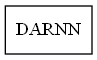

In [60]:
plot_model(model, to_file='model_plot.png',  show_layer_names=True)

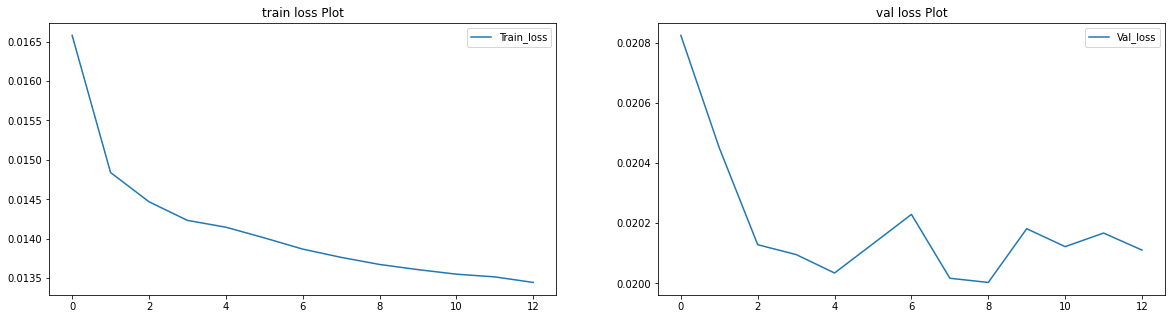

In [61]:
import matplotlib.pylab as plt
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 5))
ax1.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax1.legend(['Train_loss'], loc='upper right')
ax2.legend(['Val_loss'], loc='upper right')
ax1.title.set_text('train loss Plot')
ax2.title.set_text('val loss Plot')
plt.show()

In [107]:
import warnings
warnings.filterwarnings('ignore')
xtr=[]
for i in range(1914-350,1942-350):
    xtr.append(sc.transform(train_sales_concat.iloc[i-28-7:i-7]))
xtr=np.array(xtr).astype(np.float32)
np.shape(xtr)

(28, 28, 30495)

In [108]:
pre= model.predict(xtr[0].reshape(1,28,30495))
np.shape(pre)

(1, 30490)

In [109]:
#predicting the sales for next 28 days for 30490 products
preddd=[]
for i in range(0,28):
    pre= model.predict(xtr[i].reshape(1,28,30495))
    testInput = np.column_stack((np.array(pre),
                                 daysBeforeEvent1.iloc[1913 + i],
                                 daysBeforeEvent2.iloc[1913 + i],
                                 snap_CA.iloc[1913 + i],
                                snap_TX.iloc[1913 + i],
                                snap_WI.iloc[1913 + i]))
    predd=sc.inverse_transform(testInput)[:,0:30490]
    preddd.append(predd)
np.shape(preddd)

(28, 1, 30490)

In [110]:
submission_eval = pd.DataFrame(data=np.array(preddd).reshape(28,30490))
submission_eval

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
0,0.614210,0.176935,0.698582,0.905816,0.585753,0.410511,0.192717,7.293255,-0.001183,0.352661,...,0.929218,0.385119,1.031906,1.227795,0.254540,0.980026,-0.003919,0.191986,0.950166,1.335578
1,0.614562,0.185951,0.724987,0.768504,0.600732,0.283692,0.194354,7.869892,-0.043232,0.306926,...,1.020430,0.420810,1.058165,1.326229,0.346732,0.895199,0.003914,0.194390,0.958470,1.213003
2,0.620123,0.189850,0.765955,0.727976,0.608366,0.219639,0.195880,8.304425,-0.072382,0.300417,...,1.050874,0.447168,1.037425,1.350849,0.416172,0.858236,0.006972,0.196405,1.005223,1.199090
3,0.613080,0.183081,0.709118,0.824764,0.604149,0.240067,0.188989,7.790937,-0.026600,0.302598,...,0.957030,0.444661,1.064779,1.340796,0.249027,0.963295,0.003435,0.209110,0.935083,1.168832
4,0.610411,0.188769,0.809587,1.245028,0.651836,0.250121,0.185780,7.758071,-0.082447,0.463260,...,0.861971,0.486116,1.161928,1.540736,0.218826,1.093918,0.009563,0.174123,0.912652,1.441294
5,0.609272,0.184641,0.804558,1.228280,0.634914,0.299657,0.187011,7.692523,-0.073203,0.468698,...,0.854899,0.473513,1.122078,1.466541,0.236121,1.082293,0.007601,0.174151,0.940658,1.483286
6,0.593140,0.176206,0.779182,1.080145,0.591400,0.317953,0.184032,7.421518,-0.069303,0.430311,...,0.846577,0.428596,1.031339,1.335336,0.229411,1.035895,0.001582,0.162225,0.971659,1.444489
7,0.597860,0.175238,0.737981,0.890131,0.572521,0.341653,0.187374,7.361115,-0.044889,0.362009,...,0.904429,0.390047,0.988510,1.238536,0.261510,0.967127,-0.003103,0.170098,0.984000,1.344092
8,0.642681,0.195158,0.740015,0.603691,0.612262,0.283515,0.205778,8.412764,-0.044448,0.255525,...,1.151588,0.423909,1.050500,1.307306,0.503221,0.789099,0.005055,0.212740,1.015849,1.155341
9,0.632150,0.194587,0.755068,0.699306,0.621943,0.225402,0.199401,8.378687,-0.058910,0.279690,...,1.091074,0.445304,1.068865,1.370296,0.431981,0.849457,0.007105,0.205712,0.992674,1.156328


In [111]:
x=np.array(train_sales_concat.T)
y = np.array(submission_eval.T)

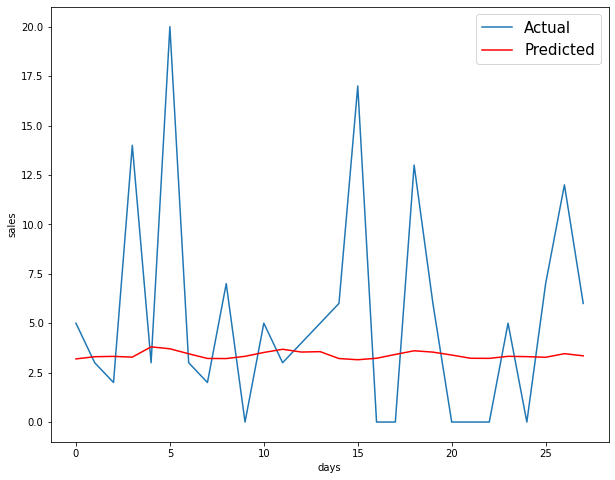

In [112]:
#Ploting the actual and predicted sales of 15th product
import matplotlib.pylab as plt
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel('days')
plt.ylabel('sales')
ax.plot(x[15,-28:], label="Actual")
ax.plot(y[15],color='red',label="Predicted")
leg = ax.legend(prop={'size': 15});

In [148]:
xtr=[]
for i in range(1760-350,1942-350):
    xtr.append(train_sales_concat.iloc[i-28-7:i-7])
xtr=np.array(xtr).astype(np.float32)
np.shape(xtr)

(182, 28, 30495)

In [149]:
#### predicting the sales of next 152 days form 30490
predd=[]
for i in range(0,182):
    pre= model.predict(xtr[i].reshape(1,28,30495))
    testInput = np.column_stack((np.array(pre),
                                 daysBeforeEvent1.iloc[1760 + i],
                                 daysBeforeEvent2.iloc[1760 + i],
                                 snap_CA.iloc[1760 + i],
                                snap_TX.iloc[1760 + i],
                                snap_WI.iloc[1760 + i]))
    testInput=sc.inverse_transform(testInput)[:,0:30490]
    predd.append(testInput)
np.shape(predd)

(182, 1, 30490)

In [150]:
import numpy
submission_eval = pd.DataFrame(data=np.array(predd).reshape(182,30490))
x=numpy.array(train_sales_concat.T)
y = np.array(submission_eval.T)

In [177]:
copy_concat=train_sales_concat.copy()
copy_concat.reset_index(inplace=True)
copy_concat=copy_concat.iloc[: , 1:]
copy_concat=copy_concat.T.iloc[:,1760-350:1941-350]
copy_concat = copy_concat.T.reset_index(drop=True).T
copy_concat
#copy_concat.drop("Factor",axis=1,inplace=True)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0,0,0,0,1,2,2,0,1,0,...,2,4,0,0,0,0,3,3,0,1
1,0,0,0,0,0,1,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,1,3,1,2,2,3,0,1,1,0,...,1,0,2,0,0,0,2,3,0,1
3,3,3,2,2,2,4,3,0,5,1,...,1,1,0,4,0,1,3,0,2,6
4,2,0,0,0,0,0,2,1,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oneDayBeforeEvent1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oneDayBeforeEvent2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
snap_CA,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
snap_TX,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [192]:
sixm = copy_concat.iloc[100,:].to_frame()
sixm['MA'] = sixm.rolling(30).mean()
yma = submission_eval.T.iloc[100,:].to_frame()
yma['MA'] = yma.rolling(30).mean()
sixm

,100,MA
0,0,NaN
1,0,NaN
2,0,NaN
3,0,NaN
4,0,NaN
...,...,...
176,2,0.333333
177,3,0.433333
178,0,0.433333
179,0,0.433333


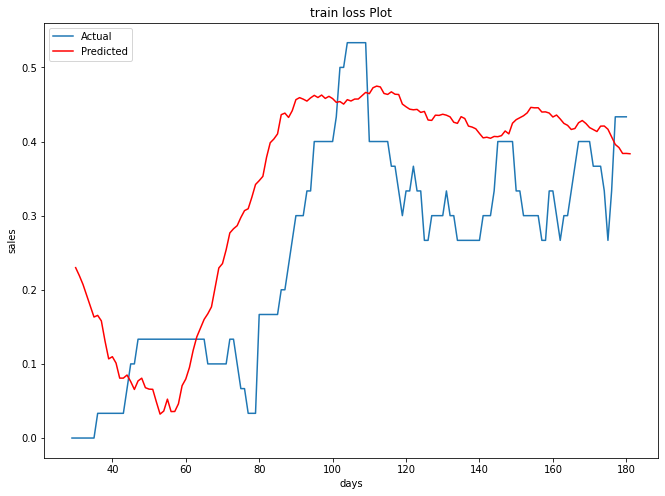

In [197]:
#ploting the actual sales vs predivted sales of 100th product
import matplotlib.pylab as plt
fig1, ax1 = plt.subplots(figsize=(11, 8))
plt.xlabel('days')
plt.ylabel('sales')
ax1.plot(sixm.iloc[-152:,1], label="Actual")
ax1.plot(yma.iloc[-152:,1],color='red',label="Predicted")
ax1.legend(loc='upper left')
ax1.title.set_text('train loss Plot')

### Improvements

* Add more features for improving predictions. Through feature engineering we could embed season, quarter, month start/end, day of the week and week of the month. 
* Moving standard deviation could also be explored.


###  References
* Livieris, Ioannis E., Emmanuel Pintelas, and Panagiotis Pintelas. "A CNN–LSTM model for gold price time-series forecasting." Neural computing and applications 32.23 (2020): 17351-17360.
* Lu, Wenjie, et al. "A CNN-LSTM-based model to forecast stock prices." Complexity 2020 (2020).
* Qin, Yao, et al. "A dual-stage attention-based recurrent neural network for time series prediction." arXiv preprint arXiv:1704.02971 (2017).
* Ensafi, Yasaman, et al. "Time-series forecasting of seasonal items sales using machine learning–A comparative analysis." International Journal of Information Management Data Insights 2.1 (2022): 100058